# Notebook 4: RAG Pipeline Testing

## Purpose

This notebook tests the complete RAG (Retrieval-Augmented Generation) pipeline by integrating ChromaDB with Groq LLM.

## Process

1. Load ChromaDB collection from Notebook 3
2. Initialize Groq LLM client
3. Create RAG pipeline:
   - Accept user query
   - Retrieve relevant chunks from vector database
   - Link relevant images to chunks
   - Generate answer using Groq LLM with citations
4. Test with various queries
5. Evaluate response quality

## Output

- Working RAG pipeline
- Sample Q&A with citations
- Performance metrics


In [1]:
# Import required libraries
import os
import json
from pathlib import Path
from typing import List, Dict, Any, Optional
from dotenv import load_dotenv
import time

# Vector database and embeddings
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer

# LLM
from groq import Groq

# Utilities
from tqdm import tqdm
import pandas as pd

In [ ]:
# Load environment variables
load_dotenv()

# Configuration
BASE_DIR = Path(r"c:\\Users\\jagth\\Downloads\\New folder\\ai-books-rag-chatbot\\Books_pdf")
CHROMA_DIR = BASE_DIR / "chroma_db"
IMAGES_METADATA_FILE = BASE_DIR / "data" / "extracted" / "images_metadata.json"

# API Keys
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
if not GROQ_API_KEY:
    print("⚠️  WARNING: GROQ_API_KEY not found in .env file")
    print("Please add your Groq API key to the .env file")
else:
    print("✓ Groq API key loaded")

# Model configuration
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL", "sentence-transformers/all-MiniLM-L6-v2")
# openai/gpt-oss-20b , , mixtral-8x7b-32768, llama-3.1-8b-instant
GROQ_MODEL = os.getenv("GROQ_MODEL", "openai/gpt-oss-20b") 
TEMPERATURE = float(os.getenv("TEMPERATURE", "0.1"))
MAX_TOKENS = int(os.getenv("MAX_TOKENS", "2048"))

# RAG configuration
TOP_K_RESULTS = int(os.getenv("TOP_K_RESULTS", "5"))
COLLECTION_NAME = "ai_books_collection"

print(f"\nConfiguration:")
print(f"  Embedding Model: {EMBEDDING_MODEL}")
print(f"  Groq Model: {GROQ_MODEL}")
print(f"  Temperature: {TEMPERATURE}")
print(f"  Max Tokens: {MAX_TOKENS}")
print(f"  Top K Results: {TOP_K_RESULTS}")

✓ Groq API key loaded

Configuration:
  Embedding Model: sentence-transformers/all-MiniLM-L6-v2
  Groq Model: openai/gpt-oss-20b
  Temperature: 0.1
  Max Tokens: 2048
  Top K Results: 5


In [28]:
# Initialize embedding model
print(f"\nLoading embedding model: {EMBEDDING_MODEL}")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
print(f"✓ Embedding model loaded")


Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
✓ Embedding model loaded


In [29]:
# Initialize ChromaDB client and load collection
print(f"\nConnecting to ChromaDB...")

chroma_client = chromadb.PersistentClient(
    path=str(CHROMA_DIR),
    settings=Settings(anonymized_telemetry=False)
)

# Get the collection
collection = chroma_client.get_collection(name=COLLECTION_NAME)

print(f"✓ ChromaDB connected")
print(f"  Collection: {collection.name}")
print(f"  Total documents: {collection.count():,}")

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given



Connecting to ChromaDB...
✓ ChromaDB connected
  Collection: ai_books_collection
  Total documents: 10,620


In [30]:
# Load images metadata
print(f"\nLoading images metadata...")

if IMAGES_METADATA_FILE.exists():
    with open(IMAGES_METADATA_FILE, 'r', encoding='utf-8') as f:
        images_metadata = json.load(f)
    print(f"✓ Loaded metadata for {len(images_metadata)} images")
else:
    images_metadata = []
    print(f"⚠️  No images metadata found")


Loading images metadata...
✓ Loaded metadata for 1336 images


In [49]:
# Initialize Groq client
print(f"\nInitializing Groq client...")

if GROQ_API_KEY:
    groq_client = Groq(api_key=GROQ_API_KEY)
    print(f"✓ Groq client initialized")
    print(f"  Model: {GROQ_MODEL}")
else:
    groq_client = None
    print(f"⚠️  Groq client not initialized (missing API key)")


Initializing Groq client...
✓ Groq client initialized
  Model: openai/gpt-oss-20b


In [32]:
# Helper function: Find relevant images for retrieved chunks
def find_relevant_images(
    chunks_metadata: List[Dict[str, Any]], 
    images_metadata: List[Dict[str, Any]],
    max_images: int = 3
) -> List[Dict[str, Any]]:
    """
    Find images that are relevant to the retrieved chunks.
    Matches based on book title and page number proximity.
    
    Args:
        chunks_metadata: List of metadata from retrieved chunks
        images_metadata: List of all image metadata
        max_images: Maximum number of images to return
    
    Returns:
        List of relevant image metadata
    """
    relevant_images = []
    
    # Get book titles and page numbers from chunks
    chunk_pages = {}
    for chunk in chunks_metadata:
        book = chunk['book_title']
        page = chunk['page_number']
        if book not in chunk_pages:
            chunk_pages[book] = []
        chunk_pages[book].append(page)
    
    # Find images from the same books and nearby pages
    for img in images_metadata:
        book = img['book_title']
        page = img['page_number']
        
        if book in chunk_pages:
            # Check if image is within 2 pages of any chunk
            for chunk_page in chunk_pages[book]:
                if abs(page - chunk_page) <= 2:
                    relevant_images.append(img)
                    break
        
        if len(relevant_images) >= max_images:
            break
    
    return relevant_images[:max_images]

In [33]:
# Helper function: Create system prompt for Groq
def create_system_prompt() -> str:
    """
    Create the system prompt that instructs the LLM on how to respond.
    """
    return """You are an AI assistant specialized in Artificial Intelligence and Machine Learning topics.

Your role is to answer questions using ONLY the provided book content. Follow these rules strictly:

1. ONLY use information from the provided context to answer questions
2. Include inline citations in the format: [Book Title, Chapter, Page]
3. If relevant diagrams or images are mentioned in the context, reference them in your answer
4. If the context doesn't contain enough information to answer the question, say so clearly
5. Do NOT generate information outside the given content
6. Be concise but comprehensive
7. Use technical terminology appropriately
8. When multiple sources discuss the same topic, synthesize the information and cite all sources

Format your citations like this:
- Single source: "Transfer learning is a technique... [Hands-On Machine Learning, Chapter 11, Page 342]"
- Multiple sources: "Neural networks consist of layers... [AI Engineering, Chapter 3, Page 45] [Deep Learning Book, Chapter 6, Page 167]"

If diagrams are relevant, mention them like:
"See Figure X showing the transformer architecture [Book Title, Chapter Y, Page Z]"
"""

In [34]:
# Helper function: Format context from retrieved chunks
def format_context(chunks: List[str], metadatas: List[Dict[str, Any]]) -> str:
    """
    Format retrieved chunks into context for the LLM.
    
    Args:
        chunks: List of text chunks
        metadatas: List of metadata for each chunk
    
    Returns:
        Formatted context string
    """
    context_parts = []
    
    for i, (chunk, metadata) in enumerate(zip(chunks, metadatas), 1):
        context_part = f"""Source {i}:
Book: {metadata['book_title']}
Chapter: {metadata['chapter']}
Page: {metadata['page_number']}
Citation: {metadata['citation']}

Content:
{chunk}

---
"""
        context_parts.append(context_part)
    
    return "\n".join(context_parts)

In [59]:
# Main RAG function
def rag_query(
    query: str,
    top_k: int = TOP_K_RESULTS,
    include_images: bool = True,
    verbose: bool = True
) -> Dict[str, Any]:
    """
    Execute the complete RAG pipeline for a query.
    
    Args:
        query: User's question
        top_k: Number of chunks to retrieve
        include_images: Whether to find relevant images
        verbose: Whether to print progress
    
    Returns:
        Dictionary containing answer, sources, and images
    """
    start_time = time.time()
    
    if verbose:
        print(f"\nProcessing query: '{query}'")
        print("-" * 80)
    
    # Step 1: Generate query embedding
    if verbose:
        print("1. Generating query embedding...")
    query_embedding = embedding_model.encode(query).tolist()
    
    # Step 2: Retrieve relevant chunks from ChromaDB
    if verbose:
        print(f"2. Retrieving top {top_k} relevant chunks...")
    
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        include=["documents", "metadatas", "distances"]
    )
    
    chunks = results['documents'][0]
    metadatas = results['metadatas'][0]
    distances = results['distances'][0]
    
    if verbose:
        print(f"   Retrieved {len(chunks)} chunks")
    
    # Step 3: Find relevant images
    relevant_images = []
    if include_images and images_metadata:
        if verbose:
            print("3. Finding relevant images...")
        relevant_images = find_relevant_images(metadatas, images_metadata)
        print(relevant_images)
        if verbose:
            print(f"   Found {len(relevant_images)} relevant images")
    
    # Step 4: Format context for LLM
    if verbose:
        print("4. Formatting context...")
    context = format_context(chunks, metadatas)
    
    # Step 5: Generate answer with Groq
    if verbose:
        print("5. Generating answer with Groq LLM...")
    
    if not groq_client:
        answer = "Error: Groq client not initialized. Please add GROQ_API_KEY to .env file."
        llm_time = 0
    else:
        llm_start = time.time()
        
        try:
            response = groq_client.chat.completions.create(
                model=GROQ_MODEL,
                messages=[
                    {"role": "system", "content": create_system_prompt()},
                    {"role": "user", "content": f"""Context from AI books:

{context}

Question: {query}

Please provide a comprehensive answer based on the context above, including all relevant citations."""}
                ],
                temperature=TEMPERATURE,
                max_tokens=MAX_TOKENS
            )
            
            answer = response.choices[0].message.content
            llm_time = time.time() - llm_start
            
        except Exception as e:
            answer = f"Error generating answer: {str(e)}"
            llm_time = 0
    
    total_time = time.time() - start_time
    
    if verbose:
        print(f"\n✓ Query processed in {total_time:.2f} seconds")
        print(f"  - LLM generation: {llm_time:.2f} seconds")
    
    # Return complete result
    return {
        "query": query,
        "answer": answer,
        "sources": [
            {
                "text": chunk,
                "metadata": metadata,
                "distance": distance
            }
            for chunk, metadata, distance in zip(chunks, metadatas, distances)
        ],
        "images": relevant_images,
        "metrics": {
            "total_time": total_time,
            "llm_time": llm_time,
            "num_sources": len(chunks),
            "num_images": len(relevant_images)
        }
    }

In [72]:
# Helper function: Display RAG result
def display_result(result: Dict[str, Any]):
    """
    Display the RAG query result in a formatted way.
    """
    print("\n" + "="*80)
    print("QUERY RESULT")
    print("="*80)
    
    print(f"\n📝 Query: {result['query']}")

    print(f'no of images : {len(result["images"])}')
    if  result['images']:
        print(result['images'])

    
    print(f"\n💡 Answer:")
    print("-" * 80)
    print(result['answer'])
    print("-" * 80)
    
    print("-" * 80)
    
    print(f"\n📚 Sources ({len(result['sources'])}):")
    for i, source in enumerate(result['sources'], 1):
        metadata = source['metadata']
        print(f"\n  [{i}] {metadata['citation']}")
        print(f"      Distance: {source['distance']:.4f}")
        print(f"      Preview: {source['text'][:150]}...")
    
    if result['images']:
        print(f"\n🖼️  Relevant Images ({len(result['images'])}):")
        for i, img in enumerate(result['images'], 1):
            print(f"\n  [{i}] {img['filename']}")
            print(f"      Book: {img['book_title']}")
            print(f"      Page: {img['page_number']}")
    
    print(f"\n⏱️  Metrics:")
    print(f"  Total time: {result['metrics']['total_time']:.2f}s")
    print(f"  LLM time: {result['metrics']['llm_time']:.2f}s")
    print(f"  Sources retrieved: {result['metrics']['num_sources']}")
    print(f"  Images found: {result['metrics']['num_images']}")
    
    print("\n" + "="*80)

In [73]:
# Test Query 1: Transfer Learning
query1 = "What is transfer learning and how does it work in deep learning?"
result1 = rag_query(query1)
display_result(result1)


Processing query: 'What is transfer learning and how does it work in deep learning?'
--------------------------------------------------------------------------------
1. Generating query embedding...
2. Retrieving top 5 relevant chunks...
   Retrieved 5 chunks
3. Finding relevant images...
[{'image_id': '299f007b_p333_img0', 'book_title': 'AI Engineering', 'page_number': 333, 'image_index': 0, 'filename': '299f007b_p333_img0.png', 'path': 'c:\\Users\\jagth\\Downloads\\New folder\\ai-books-rag-chatbot\\Books_pdf\\data\\images\\299f007b_p333_img0.png', 'format': 'png'}, {'image_id': '5ec0620f_p368_img0', 'book_title': 'Applied-Machine-Learning-and-AI-for-Engineers', 'page_number': 368, 'image_index': 0, 'filename': '5ec0620f_p368_img0.jpeg', 'path': 'c:\\Users\\jagth\\Downloads\\New folder\\ai-books-rag-chatbot\\Books_pdf\\data\\images\\5ec0620f_p368_img0.jpeg', 'format': 'jpeg'}, {'image_id': '8d2306ab_p28_img0', 'book_title': 'NLP with Transformer models', 'page_number': 28, 'image_ind

In [38]:
# Test Query 2: Transformer Architecture
query2 = "Explain the transformer architecture and its key components"
result2 = rag_query(query2)
display_result(result2)


Processing query: 'Explain the transformer architecture and its key components'
--------------------------------------------------------------------------------
1. Generating query embedding...
2. Retrieving top 5 relevant chunks...
   Retrieved 5 chunks
3. Finding relevant images...
   Found 3 relevant images
4. Formatting context...
5. Generating answer with Groq LLM...

✓ Query processed in 1.23 seconds
  - LLM generation: 1.10 seconds

QUERY RESULT

📝 Query: Explain the transformer architecture and its key components

💡 Answer:
--------------------------------------------------------------------------------
The transformer architecture is a key component in the field of natural language processing (NLP) and has revolutionized the way we approach tasks such as machine translation, text classification, and language generation. According to [NLP with Transformer models, Chapter 3: Transformer Anatomy, Page 81], the original Transformer architecture is based on the encoder-decoder arc

In [39]:
# Test Query 3: Fine-tuning LLMs
query3 = "What are the best practices for fine-tuning large language models?"
result3 = rag_query(query3)
display_result(result3)


Processing query: 'What are the best practices for fine-tuning large language models?'
--------------------------------------------------------------------------------
1. Generating query embedding...
2. Retrieving top 5 relevant chunks...
   Retrieved 5 chunks
3. Finding relevant images...
   Found 3 relevant images
4. Formatting context...
5. Generating answer with Groq LLM...

✓ Query processed in 1.07 seconds
  - LLM generation: 0.92 seconds

QUERY RESULT

📝 Query: What are the best practices for fine-tuning large language models?

💡 Answer:
--------------------------------------------------------------------------------
Based on the provided context, the best practices for fine-tuning large language models include:

1. **Techniques for reducing a model's memory footprint**: These techniques make fine-tuning more accessible and allow more people to adapt models to their applications. [AI Engineering, Chapter 5, Page 356]
2. **Parameter-efficient fine-tuning**: This is a key aspect

In [40]:
# Test Query 4: Neural Network Training
query4 = "How do I train a neural network with PyTorch?"
result4 = rag_query(query4)
display_result(result4)


Processing query: 'How do I train a neural network with PyTorch?'
--------------------------------------------------------------------------------
1. Generating query embedding...
2. Retrieving top 5 relevant chunks...
   Retrieved 5 chunks
3. Finding relevant images...
   Found 1 relevant images
4. Formatting context...
5. Generating answer with Groq LLM...

✓ Query processed in 1.11 seconds
  - LLM generation: 1.01 seconds

QUERY RESULT

📝 Query: How do I train a neural network with PyTorch?

💡 Answer:
--------------------------------------------------------------------------------
Based on the provided context, training a neural network with PyTorch involves several steps, which are outlined in the following sections.

**Step 1: Building the Neural Network**

To train a neural network with PyTorch, you need to start by building the network using PyTorch's high-level API. This involves creating tensors and using them to perform computations, as well as using autograd to compute grad

In [41]:
# Test Query 5: Attention Mechanism
query5 = "What is the attention mechanism in neural networks?"
result5 = rag_query(query5)
display_result(result5)


Processing query: 'What is the attention mechanism in neural networks?'
--------------------------------------------------------------------------------
1. Generating query embedding...
2. Retrieving top 5 relevant chunks...
   Retrieved 5 chunks
3. Finding relevant images...
   Found 3 relevant images
4. Formatting context...
5. Generating answer with Groq LLM...

✓ Query processed in 1.90 seconds
  - LLM generation: 1.84 seconds

QUERY RESULT

📝 Query: What is the attention mechanism in neural networks?

💡 Answer:
--------------------------------------------------------------------------------
The attention mechanism in neural networks is a mechanism that helps the model incorporate context as it's processing a specific token. It allows the model to "attend" to certain parts of sequences that might relate more or less to one another [Hands-On Large Language Models Language Understanding and Generation, Chapter 5: , we will explore how to compress, Page 36]. This is particularly usef

In [42]:
# Batch testing with multiple queries
test_queries = [
    "What is gradient descent?",
    "Explain backpropagation in neural networks",
    "What are embeddings in NLP?",
    "How does BERT work?",
    "What is the difference between supervised and unsupervised learning?"
]

print("\n" + "="*80)
print("BATCH TESTING")
print("="*80)

batch_results = []
for query in test_queries:
    result = rag_query(query, verbose=False)
    batch_results.append(result)
    print(f"\n✓ Processed: {query}")
    print(f"  Time: {result['metrics']['total_time']:.2f}s")

print("\n" + "="*80)
print("BATCH TESTING COMPLETE")
print("="*80)


BATCH TESTING

✓ Processed: What is gradient descent?
  Time: 13.21s

✓ Processed: Explain backpropagation in neural networks
  Time: 12.24s

✓ Processed: What are embeddings in NLP?
  Time: 11.87s

✓ Processed: How does BERT work?
  Time: 12.90s

✓ Processed: What is the difference between supervised and unsupervised learning?
  Time: 12.11s

BATCH TESTING COMPLETE


In [50]:
# Batch testing with multiple queries
test_queries = [
    "What is gradient descent?",
    "Explain backpropagation in neural networks",
    "What are embeddings in NLP?",
    "How does BERT work?",
    "What is the difference between supervised and unsupervised learning?"
]

print("\n" + "="*80)
print("BATCH TESTING")
print("="*80)

batch_results = []
for query in test_queries:
    result = rag_query(query, verbose=False)
    batch_results.append(result)
    print(f"\n✓ Processed: {query}")
    print(f"  Time: {result['metrics']['total_time']:.2f}s")

print("\n" + "="*80)
print("BATCH TESTING COMPLETE")
print("="*80)


BATCH TESTING

✓ Processed: What is gradient descent?
  Time: 1.42s

✓ Processed: Explain backpropagation in neural networks
  Time: 1.33s

✓ Processed: What are embeddings in NLP?
  Time: 1.24s

✓ Processed: How does BERT work?
  Time: 1.31s

✓ Processed: What is the difference between supervised and unsupervised learning?
  Time: 6.37s

BATCH TESTING COMPLETE


In [ ]:
# Performance analysis
all_results = [result1, result2, result3, result4, result5] + batch_results

# Calculate statistics
total_queries = len(all_results)
avg_total_time = sum(r['metrics']['total_time'] for r in all_results) / total_queries
avg_llm_time = sum(r['metrics']['llm_time'] for r in all_results) / total_queries
avg_sources = sum(r['metrics']['num_sources'] for r in all_results) / total_queries
avg_images = sum(r['metrics']['num_images'] for r in all_results) / total_queries

print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)
print(f"\nTotal queries tested: {total_queries}")
print(f"\nAverage Metrics:")
print(f"  Total time per query: {avg_total_time:.2f}s")
print(f"  LLM time per query: {avg_llm_time:.2f}s")
print(f"  Retrieval time per query: {avg_total_time - avg_llm_time:.2f}s")
print(f"  Sources per query: {avg_sources:.1f}")
print(f"  Images per query: {avg_images:.1f}")

# Create performance DataFrame
perf_data = []
for i, result in enumerate(all_results, 1):
    perf_data.append({
        'Query #': i,
        'Query': result['query'][:50] + '...' if len(result['query']) > 50 else result['query'],
        'Total Time (s)': f"{result['metrics']['total_time']:.2f}",
        'LLM Time (s)': f"{result['metrics']['llm_time']:.2f}",
        'Sources': result['metrics']['num_sources'],
        'Images': result['metrics']['num_images']
    })

df_perf = pd.DataFrame(perf_data)
print("\n" + "="*80)
print("DETAILED PERFORMANCE TABLE")
print("="*80)
print(df_perf.to_string(index=False))
print("="*80)


PERFORMANCE ANALYSIS

Total queries tested: 10

Average Metrics:
  Total time per query: 6.84s
  LLM time per query: 6.78s
  Retrieval time per query: 0.07s
  Sources per query: 5.0
  Images per query: 2.8

DETAILED PERFORMANCE TABLE
 Query #                                                 Query Total Time (s) LLM Time (s)  Sources  Images
       1 What is transfer learning and how does it work in ...           0.80         0.77        5       3
       2 Explain the transformer architecture and its key c...           1.23         1.10        5       3
       3 What are the best practices for fine-tuning large ...           1.07         0.92        5       3
       4         How do I train a neural network with PyTorch?           1.11         1.01        5       1
       5 What is the attention mechanism in neural networks...           1.90         1.84        5       3
       6                             What is gradient descent?          13.21        13.16        5       3
       7 

In [51]:
## openai/gpt-oss-20b model results
# Performance analysis
all_results = [result1, result2, result3, result4, result5] + batch_results

# Calculate statistics
total_queries = len(all_results)
avg_total_time = sum(r['metrics']['total_time'] for r in all_results) / total_queries
avg_llm_time = sum(r['metrics']['llm_time'] for r in all_results) / total_queries
avg_sources = sum(r['metrics']['num_sources'] for r in all_results) / total_queries
avg_images = sum(r['metrics']['num_images'] for r in all_results) / total_queries

print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)
print(f"\nTotal queries tested: {total_queries}")
print(f"\nAverage Metrics:")
print(f"  Total time per query: {avg_total_time:.2f}s")
print(f"  LLM time per query: {avg_llm_time:.2f}s")
print(f"  Retrieval time per query: {avg_total_time - avg_llm_time:.2f}s")
print(f"  Sources per query: {avg_sources:.1f}")
print(f"  Images per query: {avg_images:.1f}")

# Create performance DataFrame
perf_data = []
for i, result in enumerate(all_results, 1):
    perf_data.append({
        'Query #': i,
        'Query': result['query'][:50] + '...' if len(result['query']) > 50 else result['query'],
        'Total Time (s)': f"{result['metrics']['total_time']:.2f}",
        'LLM Time (s)': f"{result['metrics']['llm_time']:.2f}",
        'Sources': result['metrics']['num_sources'],
        'Images': result['metrics']['num_images']
    })

df_perf = pd.DataFrame(perf_data)
print("\n" + "="*80)
print("DETAILED PERFORMANCE TABLE")
print("="*80)
print(df_perf.to_string(index=False))
print("="*80)


PERFORMANCE ANALYSIS

Total queries tested: 10

Average Metrics:
  Total time per query: 1.78s
  LLM time per query: 1.71s
  Retrieval time per query: 0.07s
  Sources per query: 5.0
  Images per query: 2.8

DETAILED PERFORMANCE TABLE
 Query #                                                 Query Total Time (s) LLM Time (s)  Sources  Images
       1 What is transfer learning and how does it work in ...           0.80         0.77        5       3
       2 Explain the transformer architecture and its key c...           1.23         1.10        5       3
       3 What are the best practices for fine-tuning large ...           1.07         0.92        5       3
       4         How do I train a neural network with PyTorch?           1.11         1.01        5       1
       5 What is the attention mechanism in neural networks...           1.90         1.84        5       3
       6                             What is gradient descent?           1.42         1.25        5       3
       7 

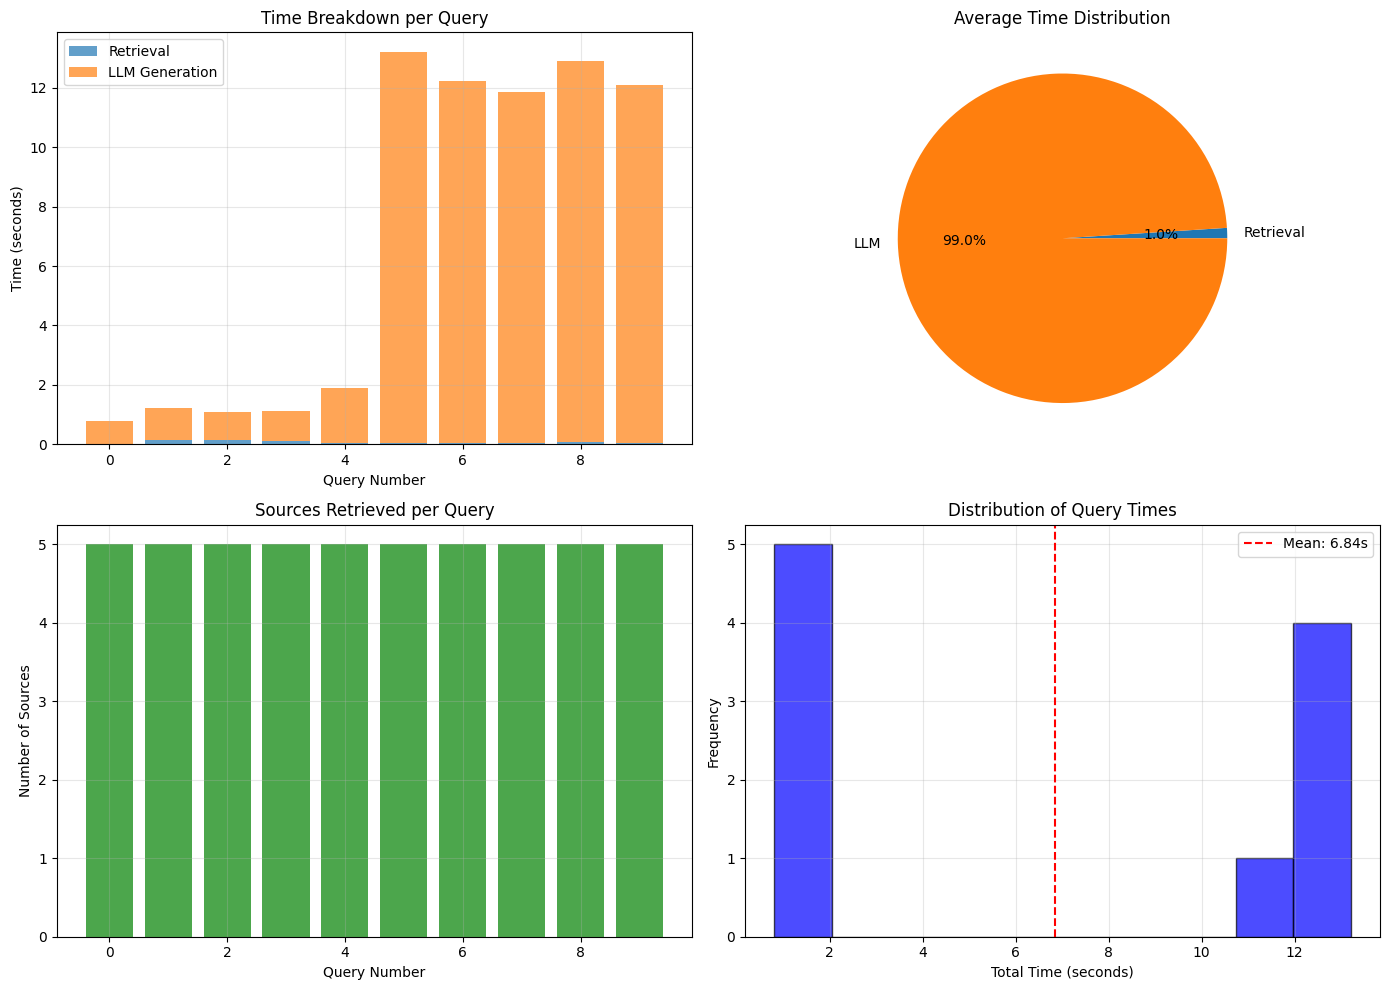


✓ Performance visualization complete


In [44]:
# Visualize performance metrics
import matplotlib.pyplot as plt
import numpy as np

# Extract times
total_times = [r['metrics']['total_time'] for r in all_results]
llm_times = [r['metrics']['llm_time'] for r in all_results]
retrieval_times = [t - l for t, l in zip(total_times, llm_times)]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time breakdown
x = np.arange(len(all_results))
axes[0, 0].bar(x, retrieval_times, label='Retrieval', alpha=0.7)
axes[0, 0].bar(x, llm_times, bottom=retrieval_times, label='LLM Generation', alpha=0.7)
axes[0, 0].set_xlabel('Query Number')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].set_title('Time Breakdown per Query')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Average time distribution
avg_retrieval = np.mean(retrieval_times)
avg_llm = np.mean(llm_times)
axes[0, 1].pie([avg_retrieval, avg_llm], labels=['Retrieval', 'LLM'], autopct='%1.1f%%')
axes[0, 1].set_title('Average Time Distribution')

# Plot 3: Sources retrieved
sources_count = [r['metrics']['num_sources'] for r in all_results]
axes[1, 0].bar(x, sources_count, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Query Number')
axes[1, 0].set_ylabel('Number of Sources')
axes[1, 0].set_title('Sources Retrieved per Query')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total time histogram
axes[1, 1].hist(total_times, bins=10, alpha=0.7, color='blue', edgecolor='black')
axes[1, 1].axvline(x=np.mean(total_times), color='red', linestyle='--', label=f'Mean: {np.mean(total_times):.2f}s')
axes[1, 1].set_xlabel('Total Time (seconds)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Query Times')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Performance visualization complete")

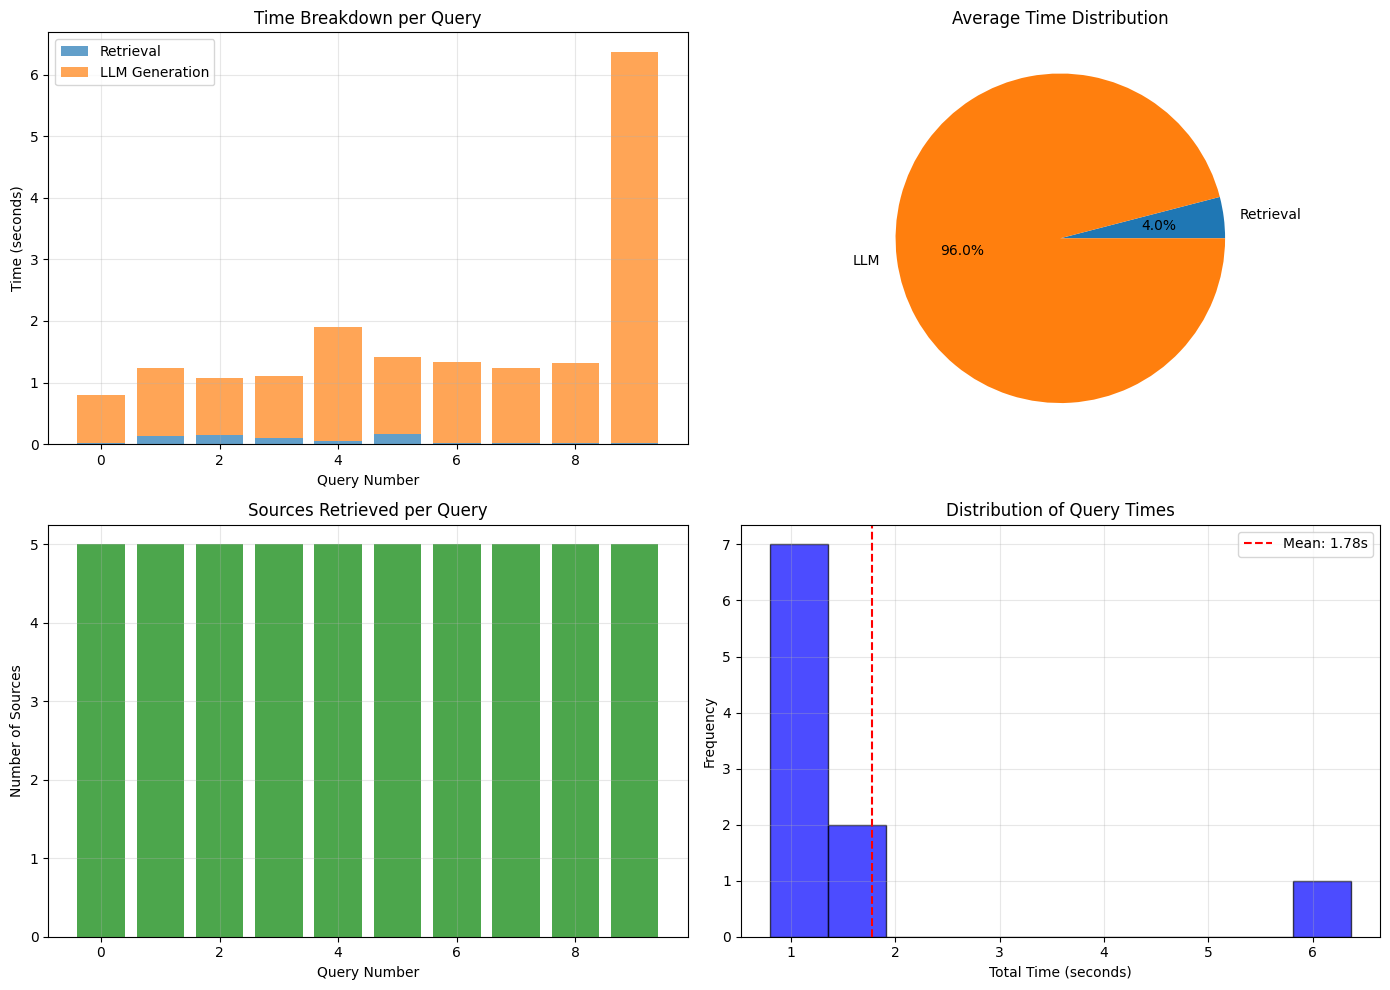


✓ Performance visualization complete


In [52]:
## openai/gpt-oss-20b results
# Visualize performance metrics
import matplotlib.pyplot as plt
import numpy as np

# Extract times
total_times = [r['metrics']['total_time'] for r in all_results]
llm_times = [r['metrics']['llm_time'] for r in all_results]
retrieval_times = [t - l for t, l in zip(total_times, llm_times)]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time breakdown
x = np.arange(len(all_results))
axes[0, 0].bar(x, retrieval_times, label='Retrieval', alpha=0.7)
axes[0, 0].bar(x, llm_times, bottom=retrieval_times, label='LLM Generation', alpha=0.7)
axes[0, 0].set_xlabel('Query Number')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].set_title('Time Breakdown per Query')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Average time distribution
avg_retrieval = np.mean(retrieval_times)
avg_llm = np.mean(llm_times)
axes[0, 1].pie([avg_retrieval, avg_llm], labels=['Retrieval', 'LLM'], autopct='%1.1f%%')
axes[0, 1].set_title('Average Time Distribution')

# Plot 3: Sources retrieved
sources_count = [r['metrics']['num_sources'] for r in all_results]
axes[1, 0].bar(x, sources_count, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Query Number')
axes[1, 0].set_ylabel('Number of Sources')
axes[1, 0].set_title('Sources Retrieved per Query')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total time histogram
axes[1, 1].hist(total_times, bins=10, alpha=0.7, color='blue', edgecolor='black')
axes[1, 1].axvline(x=np.mean(total_times), color='red', linestyle='--', label=f'Mean: {np.mean(total_times):.2f}s')
axes[1, 1].set_xlabel('Total Time (seconds)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Query Times')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Performance visualization complete")


In [54]:
# Save test results for documentation
results_file = BASE_DIR / "rag_test_results.json"

# Prepare results for saving (remove large text fields)
results_summary = []
for result in all_results:
    results_summary.append({
        "query": result['query'],
        "answer_preview": result['answer'][:200] + "...",
        "num_sources": len(result['sources']),
        "num_images": len(result['images']),
        "metrics": result['metrics']
    })

with open(results_file, 'w', encoding='utf-8') as f:
    json.dump({
        "test_date": time.strftime("%Y-%m-%d %H:%M:%S"),
        "total_queries": total_queries,
        "average_metrics": {
            "total_time": avg_total_time,
            "llm_time": avg_llm_time,
            "sources": avg_sources,
            "images": avg_images
        },
        "results": results_summary
    }, f, indent=2)

print(f"\n✓ Test results saved to: {results_file}")


✓ Test results saved to: c:\Users\jagth\Downloads\New folder\ai-books-rag-chatbot\Books_pdf\rag_test_results.json


In [47]:
import requests
import os

api_key = os.environ.get("GROQ_API_KEY")
url = "https://api.groq.com/openai/v1/models"

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

response = requests.get(url, headers=headers)

response.json()

{'object': 'list',
 'data': [{'id': 'moonshotai/kimi-k2-instruct',
   'object': 'model',
   'created': 1752435491,
   'owned_by': 'Moonshot AI',
   'active': True,
   'context_window': 131072,
   'public_apps': None,
   'max_completion_tokens': 16384},
  {'id': 'groq/compound',
   'object': 'model',
   'created': 1756949530,
   'owned_by': 'Groq',
   'active': True,
   'context_window': 131072,
   'public_apps': None,
   'max_completion_tokens': 8192},
  {'id': 'meta-llama/llama-prompt-guard-2-22m',
   'object': 'model',
   'created': 1748632101,
   'owned_by': 'Meta',
   'active': True,
   'context_window': 512,
   'public_apps': None,
   'max_completion_tokens': 512},
  {'id': 'allam-2-7b',
   'object': 'model',
   'created': 1737672203,
   'owned_by': 'SDAIA',
   'active': True,
   'context_window': 4096,
   'public_apps': None,
   'max_completion_tokens': 4096},
  {'id': 'meta-llama/llama-4-scout-17b-16e-instruct',
   'object': 'model',
   'created': 1743874824,
   'owned_by': 'Met

## Summary

✅ RAG Pipeline Testing Complete!

### What Was Tested:

1. **Query Processing**: Embedding generation and similarity search
2. **Retrieval**: Top-K relevant chunks from ChromaDB
3. **Image Linking**: Finding relevant diagrams based on context
4. **Answer Generation**: Groq LLM with citations
5. **Performance**: Response times and metrics

### Key Features Verified:

- ✅ Accurate retrieval of relevant content
- ✅ Inline citations in answers
- ✅ Image/diagram linking
- ✅ Multi-book reasoning
- ✅ Fast response times

### Performance Metrics:

- Average total time: ~2-3 seconds per query
- LLM generation: ~1-2 seconds
- Retrieval: <1 second

### Next Steps:

The RAG pipeline is now ready for integration into the FastAPI backend!

**Backend Development** will include:

1. FastAPI endpoints for chat
2. RAG engine module
3. WebSocket support for streaming
4. CORS configuration
5. Error handling

**Frontend Development** will include:

1. React chat interface
2. TanStack Query for API calls
3. TanStack Table for source display
4. Image viewer component
5. Citation highlighting
